In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import importlib
from simulator.ideal import SimulatorIdeal
from simulator.lennard import SimulatorLennard
from simulator.magnetic import SimulatorMagnetic

import multiprocessing
from multiprocessing import Pool, cpu_count
from relaxation.estimators import RelaxationFinder
# import logging.config
# import logging
from utils.logs import get_logger
from tqdm.notebook import tqdm 

import sys, os, time
# logging.config.fileConfig("/home/amatevosyan/telegramLogConfig")
# logger = logging.getLogger("telegram")

# logger = multiprocessing.log_to_stderr()
# logger.setLevel(logging.WARNING)

In [2]:
def before_step(obj, r, v, t):
    if not hasattr(obj, "Bz_dummy"):
        obj.Bz_dummy = obj.Bz
        obj.abc_dummy = obj.abc.copy()
        
        obj.Bz = 0
        obj.abc[1] = obj.abc[0]
        obj.init_potential_params()
        
    if t > 100:
        obj.Bz = obj.Bz_dummy
        obj.abc = obj.abc_dummy
        obj.init_potential_params()
        obj.last_a = None

In [3]:
if "pool" in dir():
    pool.close()
    print("closed")
pool = Pool(cpu_count(), maxtasksperchild=1); pool

<multiprocessing.pool.Pool state=RUN pool_size=32>

 49%|█████████████████████████████████████████████████████▍                                                       | 489924/1000000 [37:55<41:52, 203.01it/s]

In [4]:
params_model = {
    "group_name" : "Ensemble 5",
    "R" : 1.0,
    "Rz" : 0.25,
    "Bz" : 0,
    "eccentricity": 0.00,
    "sigma":0.05,
    "epsilon":0.1,
    "get_logger" : get_logger
}
params_init = {
#     "energy": 10,
#     "sigma_grid":2,
    "position_random_shift_percentage": 50.0/100,
#     "angular_momentum_factor" : 0.99,
#     "angular_momentum" : 60,
    "planar": False,
    "zero_momentum": False,
}
params_simulation = {
    "iteration_time" : 1000,
    "dt" : 1e-3,
    "record_interval" : 1e-1,
    "algorithm" : "VERLET",
#     "before_step" : before_step
}

sz = 35
grid = [x.flatten() for x in np.meshgrid(np.logspace(0.1, 10, sz),np.linspace(0,0.97,sz), np.linspace(0.1, 2,sz))]
perm = np.random.permutation(len(grid[0]))
grid = [x[perm] for x in grid]

count = 0
for energy, angular_momentum_factor, sigma_grid in tqdm(zip(*grid), total=len(grid[0])):

    N_pred = ((energy / sigma_grid**2)**(1.5)*4.2)
    if N_pred < 10 or N_pred > 205:
        continue
    sim = SimulatorMagnetic(**params_model)
    sim.init_positions_closepack(
        energy=energy, angular_momentum_factor=angular_momentum_factor, sigma_grid=sigma_grid,**params_init)
    sim.init_velocities(
        energy=energy, angular_momentum_factor=angular_momentum_factor, sigma_grid=sigma_grid,**params_init);
#     (sim.angular_momentum(sim.r_init, sim.v_init)[2].sum(),
#      sim.total_energy(sim.r_init, sim.v_init),
#      sim.particle_number())
#     print(sim.particle_number())
#     break
    if sim.particle_number() > 10 and sim.particle_number() < 200:
        count += 1
        pool.apply_async(sim.simulate_async, kwds=params_simulation)
# count 

count

  0%|          | 0/42875 [00:00<?, ?it/s]

3010

  7%|███████▏                                                                                                      | 65861/1000000 [03:06<42:13, 368.71it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 52%|████████████████████████████████████████████████████████▋                                                    | 519759/1000000 [29:00<31:32, 253.78it/s]

In [20]:
sim.simulate(**params_simulation);
RelaxationFinder(sim, None,verbose=True).summarize()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.01it/s]


{'col-1': 2.8332415576005077,
 'col-1.06': 2.2925654198327443,
 'col-1.12': 2.019585242407412,
 'csim-3': 0.014433321927183662,
 'csim-4': 0.4416843408414869,
 'csim-9': 0.1469138954590929,
 'csim-m': 0.1707967766609962,
 'rmsd': 1.7,
 'rmsv': 1.9}

<AxesSubplot:>

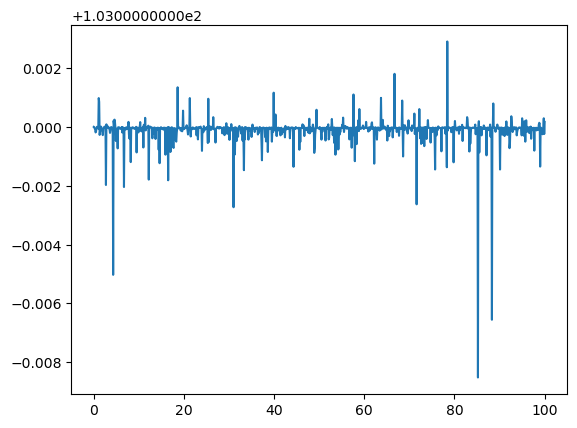

In [28]:
dfs = sim.get_data_frames()
(dfs["KE"] + dfs["PE"] + 0.5*dfs["IE"]).sum(axis=1).plot()

In [6]:
def f(i):
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    sim = SimulatorMagnetic(Bz=0, verbose=(i==0), **params_model)
    sim.init_positions_closepack(**params_init)
    sim.init_velocities(**params_init);
    sim.simulate(**params_simulation);
    dfs = sim.get_data_frames()
    return dfs["L"].sum(axis=1)

In [7]:
if "pool" in dir():
    pool.close()
    print("closed")
pool = Pool(cpu_count(), maxtasksperchild=1); pool

closed


<multiprocessing.pool.Pool state=RUN pool_size=32>

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [19:28<00:00, 855.55it/s]


In [8]:
res = pool.map(f, range(32))

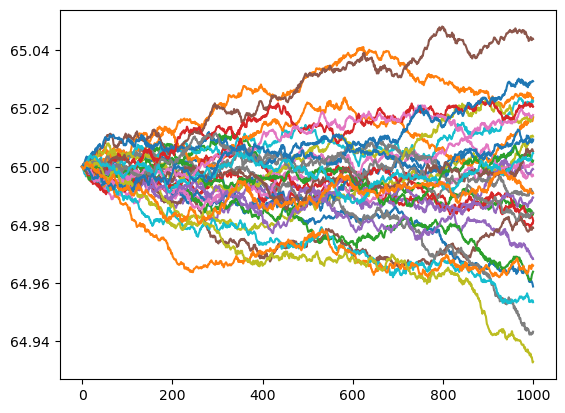

In [9]:
df = pd.DataFrame(res).T
df.loc[:].plot()
plt.gca().get_legend().remove()

In [11]:
def plot_mean_std(df, color, label):
    m = df.mean(axis=1)
    std = df.std(axis=1)
    m.plot(color=color, label=label)
    plt.fill_between(df.index, (m + std), (m - std), color=color, alpha=0.1)

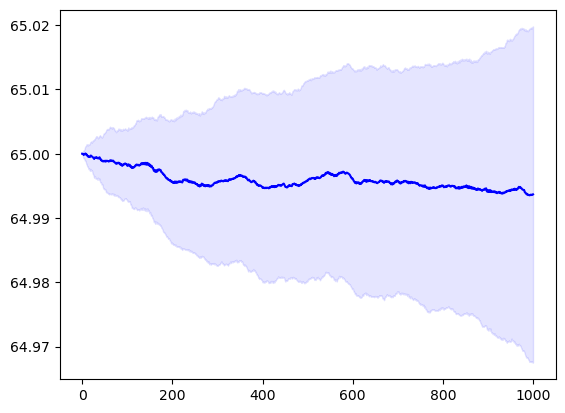

In [12]:
plot_mean_std(df, "b", "")

In [29]:
if "pool" in dir():
    pool.close()
    print("closed")
pool = Pool(cpu_count(), maxtasksperchild=1); pool

closed


<multiprocessing.pool.Pool state=RUN pool_size=32>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [10:42<00:00, 778.56it/s]


In [32]:
for i in range(64):
    name = f"subgroup-{i}"
    
    sim = SimulatorMagnetic(Bz=0, name=name, **params_model)
    sim.init_positions_closepack(**params_init)
    sim.init_velocities(**params_init);
    r_init, v_init = sim.r_init, sim.v_init

    pool.apply_async(sim.simulate_async, kwds=params_simulation)
    
    sim = SimulatorMagnetic(Bz=1e-1, name=name, **params_model)
    sim.r_init, sim.v_init = r_init, v_init
    pool.apply_async(sim.simulate_async, kwds=params_simulation)

 29%|███████████████████████████████▍                                                                              | 143029/500000 [02:50<07:32, 789.55it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 72%|███████████████████████████████████████████████████████████████████████████████▌                              | 361399/500000 [07:08<02:39, 869.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 23%|█████████████████████████        